In [43]:
%load_ext autoreload
%autoreload 2
from sympy import symbols, init_printing, simplify, solve, srepr, Add, Symbol, Integer, Float, pi, cos, sin, Rational
from sympy import IndexedBase, Eq, simplify, sqrt, latex
from mako.template import Template
from mako.lookup import TemplateLookup
from mako.runtime import Context
from StringIO import StringIO
from grid import *
init_printing()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
Txx = Field('Txx', (False,False,False,False))
Tyy = Field('Tyy', (False,False,False,False))
Tzz = Field('Tzz', (False,False,False,False))
Txy = Field('Txy', (False,True,True,False))
Tyz = Field('Tyz', (False,False,True,True))
Txz = Field('Txz', (False,True,False,True))
U = Field('U', (True,True,False,False))
V = Field('V', (True,False,True,False))
W = Field('W', (True,False,False,True))

In [45]:
grid = StaggeredGrid3D()
grid.set_stress_fields([Txx,Tyy,Tzz,Txy,Tyz,Txz])
grid.set_velocity_fields([U,V,W])
U.associate_stress_fields((Txx,Txy,Txz))
V.associate_stress_fields((Txy,Tyy,Tyz))
W.associate_stress_fields((Txz,Tyz,Tzz))
grid.set_domain_size((1.0,1.0,1.0))
grid.set_spacing((0.02,0.02,0.02))
grid.set_time_step(0.01,1.0)

####Analytical solutions
$U = cos(\pi x)(sin(\pi y)-sin(\pi z))cos(\Omega t)$<br>
$V = cos(\pi y)(sin(\pi z)-sin(\pi x))cos(\Omega t)$<br>
$W = cos(\pi z)(sin(\pi x)-sin(\pi y))cos(\Omega t)$<br>
$T_{xx} = -Asin(\pi x)(sin(\pi y)-sin(\pi z))sin(\Omega t)$<br>
$T_{yy} = -Asin(\pi y)(sin(\pi z)-sin(\pi x))sin(\Omega t)$<br>
$T_{zz} = -Asin(\pi z)(sin(\pi x)-sin(\pi y))sin(\Omega t)$<br>
$T_{xy} = T_{yz} = T_{xz} = 0$<br>
where $A=\sqrt{2\rho \mu} \space \space b=\pi\sqrt{\frac{2\mu}{\rho}}$

In [46]:
rho, beta, lam, mu = symbols('rho beta lambda mu')
t,x,y,z = symbols('t x y z')
grid.set_index((t,x,y,z))
grid.set_symbol(rho,1.0)
grid.set_symbol(beta,1.0)
grid.set_symbol(lam,0.5)
grid.set_symbol(mu,0.5)
Omega = pi*sqrt(2*mu/rho)
A = sqrt(2*rho*mu)
U_func = cos(pi*x)*(sin(pi*y)-sin(pi*z))*cos(Omega*t)
V_func = cos(pi*y)*(sin(pi*z)-sin(pi*x))*cos(Omega*t)
W_func = cos(pi*z)*(sin(pi*x)-sin(pi*y))*cos(Omega*t)
Txx_func = -A*sin(pi*x)*(sin(pi*y)-sin(pi*z))*sin(Omega*t)
Tyy_func = -A*sin(pi*y)*(sin(pi*z)-sin(pi*x))*sin(Omega*t)
Tzz_func = -A*sin(pi*z)*(sin(pi*x)-sin(pi*y))*sin(Omega*t)
Txy_func = Float(0)
Tyz_func = Float(0)
Txz_func = Float(0)

In [47]:
U.set_analytic_func(U_func)
V.set_analytic_func(V_func)
W.set_analytic_func(W_func)
Txx.set_analytic_func(Txx_func)
Tyy.set_analytic_func(Tyy_func)
Tzz.set_analytic_func(Tzz_func)
Txy.set_analytic_func(Txy_func)
Tyz.set_analytic_func(Tyz_func)
Txz.set_analytic_func(Txz_func)

In [48]:
grid.calc_derivatives()

###PDEs
#####momentum equations
$\partial_tU = b(\partial_xT_{xx}+\partial_yT_{xy}+\partial_zT_{xz})$<br>
$\partial_tV = b(\partial_xT_{xy}+\partial_yT_{yy}+\partial_zT_{yz})$<br>
$\partial_tW = b(\partial_xT_{xz}+\partial_yT_{yz}+\partial_zT_{zz})$<br>
#####stress-strain equations
$\partial_tT_{xx} = (\lambda+2\mu)\partial_xU + \lambda(\partial_yV+\partial_zW)$<br>
$\partial_tT_{yy} = (\lambda+2\mu)\partial_yV + \lambda(\partial_xU+\partial_zW)$<br>
$\partial_tT_{zz} = (\lambda+2\mu)\partial_zW + \lambda(\partial_xU+\partial_yV)$<br>
$\partial_tT_{xy} = \mu(\partial_yU + \partial_xV)$<br>
$\partial_tT_{xz} = \mu(\partial_zU + \partial_xW)$<br>
$\partial_tT_{yz} = \mu(\partial_zV + \partial_yW)$<br>

In [49]:
# momentum equations
eq1 = Eq(U.d[0][1], beta*(Txx.d[1][2] + Txy.d[2][2] + Txz.d[3][2]))
eq2 = Eq(V.d[0][1], beta*(Txy.d[1][2] + Tyy.d[2][2] + Tyz.d[3][2]))
eq3 = Eq(W.d[0][1], beta*(Txz.d[1][2] + Tyz.d[2][2] + Tzz.d[3][2]))
# stress-strain equations
eq4 = Eq(Txx.d[0][1], (lam + 2*mu)*U.d[1][2] + lam*(V.d[2][2]+W.d[3][2]))
eq5 = Eq(Tyy.d[0][1], (lam + 2*mu)*V.d[2][2] + lam*(U.d[1][2]+W.d[3][2]))
eq6 = Eq(Tzz.d[0][1], (lam + 2*mu)*W.d[3][2] + lam*(U.d[1][2]+V.d[2][2]))
eq7 = Eq(Txy.d[0][1], mu*(U.d[2][2] + V.d[1][2]))
eq8 = Eq(Tyz.d[0][1], mu*(V.d[3][2] + W.d[2][2]))
eq9 = Eq(Txz.d[0][1], mu*(U.d[3][2] + W.d[1][2]))

In [50]:
grid.solve_fd([eq1,eq2,eq3,eq4,eq5,eq6,eq7,eq8,eq9])

In [61]:
Txx_expr = (lam + 2*mu)*U.d[1][1] + lam*(V.d[2][1]+W.d[3][1]); Txx.set_dt(Txx_expr)
Tyy_expr = (lam + 2*mu)*V.d[2][1] + lam*(U.d[1][1]+W.d[3][1]); Tyy.set_dt(Tyy_expr)
Tzz_expr = (lam + 2*mu)*W.d[3][1] + lam*(U.d[1][1]+V.d[2][1]); Tzz.set_dt(Tzz_expr)
Txy_expr = mu*(U.d[2][1] + V.d[1][1]); Txy.set_dt(Txy_expr)
Tyz_expr = mu*(V.d[3][1] + W.d[2][1]); Tyz.set_dt(Tyz_expr)
Txz_expr = mu*(U.d[3][1] + W.d[1][1]); Txz.set_dt(Txz_expr)

In [62]:
grid.set_free_surface_boundary(1,0);grid.set_free_surface_boundary(1,1)
grid.set_free_surface_boundary(2,0);grid.set_free_surface_boundary(2,1)
grid.set_free_surface_boundary(3,0);grid.set_free_surface_boundary(3,1)

###output using templates

In [65]:
# write to template file
mylookup = TemplateLookup(directories=['templates/staggered','templates/'])
mytemplate = mylookup.get_template('staggered3d_tmpl.cpp')
buf = StringIO()
dict1 = {'define_constants':grid.define_const(),'declare_fields':grid.declare_fields(),'initialise':grid.initialise(),'initialise_bc':grid.initialise_boundary(),'stress_loop':grid.stress_loop(),'velocity_loop':grid.velocity_loop(),'stress_bc':grid.stress_bc(),'velocity_bc':grid.velocity_bc(),'output':grid.converge_test()}
ctx = Context(buf, **dict1)
mytemplate.render_context(ctx)
code = buf.getvalue()
# generate compilable C++ source code
f= open('test.cpp','w')
f.write(code)
f.close()

In [64]:
W.bc[3][0]

'W[t][x][y][1]=(dx*dy*lambda*W[t][x][y][3] + 2*dx*dy*mu*W[t][x][y][3] + dx*dz*lambda*V[t][x][y][2] - dx*dz*lambda*V[t][x][y - 1][2] + dy*dz*lambda*U[t][x][y][2] - dy*dz*lambda*U[t][x - 1][y][2])/(dx*dy*(lambda + 2*mu));\n\t\t\t'

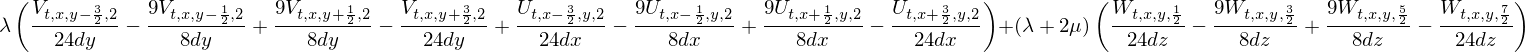

In [60]:
Tzz_expr.subs(z,2)

In [ ]:
lhs = W.name[t,x,y,]
solve(Tzz_expr.subs(z,2),